# Création du jeu

## Installation des bibliothèques

In [60]:
#Installation
!sudo apt-get update
!pip install pygame
!pip install tensorflow
!pip install tf-agents[reverb]

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:14 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic

## Import des modules

In [61]:
import pygame
import random as r
import math
import numpy as np

#TensorFlow
import tensorflow as tf
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.environments import py_environment
from tf_agents.specs import array_spec
from tf_agents.trajectories import time_step as ts
from tf_agents.networks import actor_distribution_network
from tf_agents.agents.reinforce import reinforce_agent
from tf_agents.specs import tensor_spec
from tf_agents.networks import sequential
from tf_agents.agents.dqn import dqn_agent
from tf_agents.utils import common
from tf_agents.policies import random_tf_policy
from tf_agents.drivers import py_driver
from tf_agents.policies import py_tf_eager_policy

#Reverb
import reverb
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils

## Création des classes

In [62]:
class wall():
    def __init__(self,instanceEnv):
        ## Env Variables ##
        self.env = instanceEnv

        ## Wall Variables ##
        # Same random seed for every creation of wall
        r.seed(1000) #1000
        # number of brick per row and per column
        self.rows = 6
        self.cols = 5
        #Sizes
        self.wallHeight = (self.env.height - 100) // 2
        self.brickHeight = self.wallHeight // self.rows

        #Table for storing bricks
        self.bricks = []
        #Number of breakable bricks
        self.breakableBricks = 0
        
        # border of the bricks (gap between bricks)
        self.border = 3
        self.brickWidth = self.env.width // self.cols

        #Save of the wall in order to reset the episode
        self.save = []

    def createBricks(self):
        for rowNumber in range(self.rows):
            for colNumber in range(self.cols):
                # Create Rectancle for each brick
                brick = pygame.Rect(
                    colNumber*self.brickWidth, 100+rowNumber*self.brickHeight, self.brickWidth, self.brickHeight)
                
                # 25% unbreakable bricks
                type = r.randint(0,3)
                if type != 0:
                    self.breakableBricks+=1

                # Store bricks inside table
                self.bricks.append(
                    (colNumber, rowNumber, type, brick))

                colNumber += 1
            rowNumber += 1
        #Save the wall 
        self.save = self.bricks.copy()

    def resetBricks(self):
        self.bricks = self.save.copy()      

    def printWall(self,screen):
        for brick in self.bricks:
            # check for unbreakable bricks
            if(brick[2] == 0):
                color = self.env.color1
            else:
                color = self.env.color2
            
            # print bricks
            pygame.draw.rect(screen, (color),
                             ((brick[3].x + self.border), (brick[3].y + self.border), self.brickWidth - 2*self.border, self.brickHeight - 2*self.border))

class paddle():
    def __init__(self,instanceEnv):
        ## Env Variables ##
        self.env = instanceEnv

        ## Paddle Variables ##
        # Sizes
        self.paddleWidth = self.env.width // 5
        self.paddleHeight = 10
        # Initial Position
        self.x = (self.env.width - self.paddleWidth)/2  
        self.y = self.env.height - 60
        #Create teh rectangle of the paddle
        self.rect = pygame.Rect(
            self.x, self.y, self.paddleWidth, self.paddleHeight)
        #Speed of the paddle
        self.speed = 8

    def printPaddle(self,screen):
        pygame.draw.rect(screen, self.env.color3, self.rect)     

    def move(self):
        # get key pressed
        key = pygame.key.get_pressed()

        # move left
        if key[pygame.K_LEFT] and self.rect.left > 0:
            self.rect.x -= self.speed

        # move right
        if key[pygame.K_RIGHT] and self.rect.right < self.env.width:
            self.rect.x += self.speed

class ball():
    def __init__(self,instanceEnv):
        ## Env Variables ##
        self.env = instanceEnv

        ## Ball Variables ##
        # Initial speed of the ball on each axes
        self.ballSpeed = 2.5  # on Axes at the beginning
        self.speedx = self.ballSpeed
        self.speedy = -self.ballSpeed

        # Global Velocity of the ball
        self.velocity = math.sqrt(2*(self.ballSpeed**2))

        # Radius of the ball
        self.rad = 10

        # Initial position of the ball
        self.x = self.env.width // 2 - self.rad  # init position of the rectangle
        self.y = self.env.height - 90            # init position of the rectangle

        # Create a rectangle around the ball
        self.rect = pygame.Rect(
            self.x, self.y, 2*self.rad, 2*self.rad)

        #Horizontal Direction (from the left to the right = 1)
        self.directionH = 1

        #Angle of the colision between the ball and the paddle (or the wall)
        self.angle = -1
        #Angle of the redirection after colision
        self.newAngle = -1

        #Save the nature of the colision (wall, screen, or paddle)
        self.lastCollision = ""

        # margin Error for Colisions
        self.margin = 5

    def printBall(self,screen):
        pygame.draw.circle(screen, self.env.color3, (self.rect.x +
                                            self.rad, self.rect.y + self.rad), self.rad)
        
    def move(self, paddleRect, wallBricks):
        #reset lastCollision
        self.lastCollision = ""

        # Add speed every tick to the ball's coordinates
        self.x += self.speedx
        self.y += self.speedy

        # Update the position of the ball
        self.rect.x = self.x
        self.rect.y = self.y

        #-- Check for screen borders --#
        # left and right borders
        if self.rect.right > self.env.width or self.rect.left < 0:
            self.speedx *= -1
            #save collision for reward
            self.lastCollision = "sideBorder"

        # top border
        elif self.rect.top < 0:
            self.speedy *= -1
            #save collision for reward
            self.lastCollision = "topBorder"

        # bottom border
        elif self.rect.bottom > self.env.height:
            #save collision for reward
            self.lastCollision = "endBorder"

            # reset ball position
            self.x = self.env.width // 2 - self.rad
            self.y = self.env.height - 90
            self.rect.x = self.x
            self.rect.y = self.y
            self.speedx = self.ballSpeed
            self.speedy = -self.ballSpeed

            # reset paddle position
            paddleRect.rect.x = (self.env.width - paddleRect.paddleWidth)/2  # init position

            # get a new ball if availabe
            if self.env.balls > 0:
                # delete a ball
                self.env.balls -= 1

            else:  # no ball left
                self.env._episode_ended = True

        #-- End Check for screen borders --#

        #-- Check for collisions between ball and paddle --#
        elif self.rect.y > paddleRect.rect.y - 2*self.rad:
            if self.rect.colliderect(paddleRect):

                # TOP COLLISION
                # check if ball is on top of the trail (between the 5px margin)
                if(abs(self.rect.bottom - paddleRect.rect.y) < self.margin and self.speedy > 0):

                    #save collision for reward
                    self.lastCollision = "top"

                    # calculate angle between the ball's path and the trail
                    if self.speedx == 0:
                        self.angle = 90
                    else:
                        self.angle = abs(math.degrees(
                            math.atan(self.speedy/abs(self.speedx))))

                    if(self.speedx > 0):
                        self.directionH = 1  # from the left
                    else:
                        self.directionH = -1  # from the right

                    # change x if not on the middle of the paddle

                    # LEFT PART
                    if self.rect.right >= paddleRect.rect.x and self.rect.left < paddleRect.rect.x + (0.2 * paddleRect.paddleWidth):

                        if self.directionH == 1:  # from the left
                            # increase angle by 35%
                            if self.angle < 30:
                                self.newAngle = self.angle*1.35

                            elif self.angle > 60:  # increase angle by 25%
                                self.newAngle = self.angle*1.25

                            else:  # increase angle by 30%
                                self.newAngle = self.angle*1.30

                        else:  # from the right
                            # reduce angle by 35%
                            if self.angle < 30:
                                self.newAngle = self.angle*0.65

                            elif self.angle > 60:  # reduce angle by 25%
                                self.newAngle = self.angle*0.75

                            else:  # reduce angle by 30%
                                self.newAngle = self.angle*0.70

                        self.speedx = - \
                            (math.cos(math.radians(self.newAngle)) * self.velocity)
                        self.speedy = - \
                            (math.sin(math.radians(self.newAngle)) * self.velocity)

                    # MIDDLE LEFT PART
                    elif self.rect.right >= paddleRect.rect.x + (0.2 *paddleRect.paddleWidth) and self.rect.left < paddleRect.rect.x + (0.4 *paddleRect.paddleWidth):

                        if self.directionH == 1:  # from the left
                            # increase angle by 20%
                            if self.angle < 30:
                                self.newAngle = self.angle*1.2

                            elif self.angle > 60:  # increase angle by 10%
                                self.newAngle = self.angle*1.1

                            else:  # increase angle by 15%
                                self.newAngle = self.angle*1.15

                        else:  # from the right
                            # reduce angle by 20%
                            if self.angle < 30:
                                self.newAngle = self.angle*0.8

                            elif self.angle > 60:  # reduce angle by 10%
                                self.newAngle = self.angle*0.9

                            else:  # reduce angle by 15%
                                self.newAngle = self.angle*0.85

                        self.speedx = - \
                            (math.cos(math.radians(self.newAngle)) * self.velocity)
                        self.speedy = - \
                            (math.sin(math.radians(self.newAngle)) * self.velocity)

                    elif self.rect.right >= paddleRect.rect.x + (0.4 * paddleRect.paddleWidth) and self.rect.left < paddleRect.rect.x + (0.6 * paddleRect.paddleWidth):
                        # angle is not changed
                        self.speedy *= -1

                    # MIDLE RIGHT PART
                    elif self.rect.right >= paddleRect.rect.x + (0.6 * paddleRect.paddleWidth) and self.rect.left < paddleRect.rect.x + (0.8 * paddleRect.paddleWidth):

                        if self.directionH == 1:  # from the left
                            # reduce angle by 20%
                            if self.angle < 30:
                                self.newAngle = self.angle*0.8

                            elif self.angle > 60:  # reduce angle by 10%
                                self.newAngle = self.angle*0.9

                            else:  # send the ball in opposite direction
                                # reduce angle by 15%
                                self.newAngle = self.angle*0.85

                        else:  # from the right
                            if self.angle < 30:
                                # increase angle by 20%
                                self.newAngle = self.angle*1.2

                            elif self.angle > 60:  # increase angle by 10%
                                self.newAngle = self.angle*1.1

                            else:  # increase angle by 15%
                                self.newAngle = self.angle*1.15

                        self.speedx = \
                            (math.cos(math.radians(self.newAngle)) * self.velocity)
                        self.speedy = - \
                            (math.sin(math.radians(self.newAngle)) * self.velocity)

                    # RIGHT PART
                    elif self.rect.right >= paddleRect.rect.x + (0.8 * paddleRect.paddleWidth) and self.rect.left < paddleRect.rect.x + paddleRect.paddleWidth:
                        if self.directionH == 1:  # from the left
                            # reduce angle by 35%
                            if self.angle < 30:
                                self.newAngle = self.angle*0.65

                            elif self.angle > 60:  # reduce angle by 25%
                                self.newAngle = self.angle*0.75

                            else:  # send the ball in opposite direction
                                # reduce angle by 30%
                                self.newAngle = self.angle*0.70

                        else:  # from the right
                            if self.angle < 30:
                                # increase angle by 35%
                                self.newAngle = self.angle*1.35

                            elif self.angle > 60:  # increase angle by 25%
                                self.newAngle = self.angle*1.25

                            else:  # increase angle by 30%
                                self.newAngle = self.angle*1.30

                        self.speedx = \
                            (math.cos(math.radians(self.newAngle)) * self.velocity)
                        self.speedy = - \
                            (math.sin(math.radians(self.newAngle)) * self.velocity)

                # SIDES COLLISIONS
                else:  # collision with side
                    #save collision for reward
                    self.lastCollision = "side"
                    if (abs(self.rect.left - paddleRect.rect.right) < self.margin):
                        # check direction of the ball
                        if self.speedx < 0:
                            self.speedx *= -1
                        else:  # if same direction as the paddle don't reverse direction but increase speed
                            self.speedx += 3

                    elif (abs(self.rect.right - paddleRect.rect.left) < self.margin):
                        # check direction of the ball
                        if self.speedx > 0:
                            self.speedx *= -1
                        else:  # if same direction as the paddle don't reverse direction but increase speed
                            self.speedx -= 3

        #-- End Check for collisions between ball and paddle --#

        #-- Check for collisions between ball and Bricks --#
        elif self.rect.y > 0 and self.rect.y < (self.env.height // 2) + 100:
            for brick in wallBricks:
                if(self.rect.colliderect(brick[3])):
                    # check if collision is on top or at bottom of the brick
                    if ((abs(self.rect.top - brick[3].bottom) < self.margin and self.speedy < 0) or
                            (abs(self.rect.bottom - brick[3].top) < self.margin and self.speedy > 0)):
                        # top or bottom
                        self.speedy *= -1

                    elif ((abs(self.rect.left - brick[3].right) < self.margin and self.speedx < 0) or
                          (abs(self.rect.right - brick[3].left) < self.margin and self.speedx > 0)):
                        # right or left
                        self.speedx *= -1

                    # delete the brick if breakable
                    if(brick[2] != 0):
                        wallBricks.remove(brick)
                        #add score
                        self.env.score+=1

    def gravity(self):
        if (self.speedy >= 0 and self.speedy < 1):  # stuck horizontally
            self.speedy = 1
        elif (self.speedy < 0 and self.speedy > -1):  # stuck horizontally
            self.speedy = -1

## Création de l'environnement

In [63]:
class BreakoutEnv(py_environment.PyEnvironment):
  def __init__(self, visualize, fps=10000):
    ## Init Variables ##
    # screen size
    self.width = 640
    self.height = 600   

    # remaining balls
    self.balls = 2 

    ## Init object ##
    self.wall = wall(self)
    self.paddle = paddle(self)
    self.ball = ball(self)

    # Score #
    self.score = 0

    ## Definition of actions and observation 
    #three actions : move left, move right or stand still
    self._action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int32, minimum=0, maximum=2, name='action')
        
    #observation on ball's position and paddle's position
    self._observation_spec = array_spec.BoundedArraySpec(
        shape=(2,), dtype=np.int32, minimum=0, maximum=self.width, name='observation')
    #observations are stored inside self._state
    self._state = [self.paddle.rect.x,self.ball.rect.x]

    #Check if episode is ended
    self._episode_ended = False

    #Variables for Pygame
    self.visualize = visualize 
    #Activate the visualisation
    if(visualize==True):
        # Create the screen
        self.screen = None

        # Create the clock
        self.clock = pygame.time.Clock()
        self.fps = fps

        # title
        pygame.display.set_caption('Breakout')

  def action_spec(self):
    return self._action_spec

  def observation_spec(self):
    return self._observation_spec

  def _reset(self): #a faire
    self._episode_ended = False
    #Reset wall
    self.wall.resetBricks()
    #reset remainig balls
    self.balls = 2
    #reset score
    self.score = 0

    return ts.restart(np.array(self._state, dtype=np.int32))

  def _step(self, action):
    #Check if last action ended the episode
    if self._episode_ended:
      #restart a new episode
      return self.reset()

    #Move the ball
    self.ball.move(self.paddle, self.wall.bricks)

    # Apply action
    if(action == 0 ) : #left
        if(self.paddle.rect.x - self.paddle.speed < 0):
            self.paddle.rect.x = 0
        else:
            self.paddle.rect.x -= self.paddle.speed
        self.state = self.paddle.rect.x
    elif action == 1 : #stand still
        pass
    else : # right
        if(self.paddle.rect.x + self.paddle.paddleWidth + self.paddle.speed > self.width):
            self.paddle.rect.x = self.width - self.paddle.paddleWidth
        else:
            self.paddle.rect.x += self.paddle.speed
        self.state = self.paddle.rect.x     

    #reward for beiing at same position of the ball
    if(self.ball.rect.x > self.paddle.rect.x and (self.ball.rect.x + self.ball.rad*2) < (self.paddle.rect.x + self.paddle.paddleWidth)):
        reward = 1
    else : 
        reward = -1

    if(self.visualize == True):
        #limit the clock
        self.clock.tick(self.fps)
        self.render()

    # Check if game is done
    if self._episode_ended == True: 
        return ts.termination(np.array(self._state, dtype=np.int32), reward)
    else:
        return ts.transition(np.array(self._state, dtype=np.int32), reward)

## Instanciation de l'environnement python

In [64]:
#-- Create Python Environment --#
env = BreakoutEnv(visualize=False) #add fps parameters if needed
print('Action Spec:', env.action_spec())

# check if python environement is correct
print("validate python environment")
utils.validate_py_environment(env, episodes=5)

Action Spec: BoundedArraySpec(shape=(), dtype=dtype('int32'), name='action', minimum=0, maximum=2)
validate python environment


### Test de l'environnement python

In [65]:
#Variables for testing environment
num_episode = 10  # @param {type:"integer"}
reward = 0 

In [66]:
#-- Test with Python Environment pygame --#
for i in range(num_episode):
    time_step = env.reset()
    #while episode not done
    while not time_step.is_last():
        #tensorFlow environment
        action = np.random.randint(0,3)
        time_step = env.step(action)
        reward += time_step.reward
    print("Episode "+str(i+1)+"/"+str(num_episode)+ " done : " + str(env.score) + 
    "/" + str(env.wall.breakableBricks)+" bricks")

print("reward:",reward)

Episode 1/10 done : 0/0 bricks
Episode 2/10 done : 0/0 bricks
Episode 3/10 done : 0/0 bricks
Episode 4/10 done : 0/0 bricks
Episode 5/10 done : 0/0 bricks
Episode 6/10 done : 0/0 bricks
Episode 7/10 done : 0/0 bricks
Episode 8/10 done : 0/0 bricks
Episode 9/10 done : 0/0 bricks
Episode 10/10 done : 0/0 bricks
reward: -9882.0


## Conversion vers un environnement TensorFlow

In [67]:
#-- Convert in Tensor Environment --#
tf_env = tf_py_environment.TFPyEnvironment(env)

# Check if TensorFlow environment is correct
print(isinstance(tf_env, tf_environment.TFEnvironment))
print("TimeStep Specs:", tf_env.time_step_spec())
print("Action Specs:", tf_env.action_spec())

True
TimeStep Specs: TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': BoundedTensorSpec(shape=(2,), dtype=tf.int32, name='observation', minimum=array(0, dtype=int32), maximum=array(640, dtype=int32)),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})
Action Specs: BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(2, dtype=int32))


### Test de l'environnement TensorFlow

In [68]:
#-- Test  with Tensor Environment pygame --#
for i in range(num_episode):
    time_step = tf_env.reset()
    #while episode not done
    while not time_step.is_last():
        #tensorFlow environment
        action = tf.random.uniform(shape=[], minval=0, maxval=3, dtype=tf.int32)
        time_step = tf_env.step(action)
        reward += time_step.reward
    print("Episode "+str(i+1)+"/"+str(num_episode)+ " done : " + str(env.score) + 
    "/" + str(env.wall.breakableBricks)+" bricks")

print("reward:",reward.numpy())

Episode 1/10 done : 0/0 bricks
Episode 2/10 done : 0/0 bricks
Episode 3/10 done : 0/0 bricks
Episode 4/10 done : 0/0 bricks
Episode 5/10 done : 0/0 bricks
Episode 6/10 done : 0/0 bricks
Episode 7/10 done : 0/0 bricks
Episode 8/10 done : 0/0 bricks
Episode 9/10 done : 0/0 bricks
Episode 10/10 done : 0/0 bricks
reward: [-20224.]


# Entrainement de l'IA

## Instanciation des environnements et conversion

In [69]:
#Basic environment
env = BreakoutEnv(visualize=False) #add fps parameters if needed

#Create environment
train_py_env = BreakoutEnv(visualize=False)
eval_py_env = BreakoutEnv(visualize=False) 

#Convert into tf environment
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env) 

## Récupération des actions

In [70]:
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

## Création des couches

In [71]:
learning_rate = 1e-3  # @param {type:"number"}
fc_layer_params = (100, 50) 
# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.

dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

## Création de l'agent DQN

In [72]:
#Use DQN agent to train IA
agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()


## Création des polices

In [73]:
#Create Policies
eval_policy = agent.policy
collect_policy = agent.collect_policy

#Create random policies
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())
time_step = train_env.reset()
print(random_policy.action(time_step))

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>, state=(), info=())


### Fonction pour faire la moyenne des résultats 

In [74]:
#Compute average
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

### Test avec la police aléatoire

In [75]:
num_eval_episodes = 10  # @param {type:"integer"}
#Test with random policy
print("Test with random policy")
compute_avg_return(eval_env, random_policy, num_eval_episodes)

Test with random policy


-1026.6

## Récupération des données via Reverb

In [76]:
#Use Reverb to keep track of the data
replay_buffer_max_length = 1000  # @param {type:"integer"}

table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)

agent.collect_data_spec
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

## Execution avec la police aléatoire, afin d'obtenir des données initiales

In [77]:
#Execution of the random policy in order to get data
initial_collect_steps = 100  # @param {type:"integer"}

py_driver.PyDriver(
    train_py_env, 
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

(TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([256, 310], dtype=int32),
 'reward': array(-1., dtype=float32),
 'step_type': array(1, dtype=int32)}),
 ())

## Création du Dataset pour permettre à l'agent de récuperer les informations obtenu via Reverb

In [78]:
#Create a dataset in order to let the agent get access to the replay buffer
batch_size = 64  # @param {type:"integer"}

# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

dataset

iterator = iter(dataset)
# print(iterator)

## Entrainement de l'agent

### Optimisation

In [79]:
#Train the agent
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

### Remise à zéro de l'agent

In [80]:
# Reset the train step.
agent.train_step_counter.assign(0)

<tf.Variable 'UnreadVariable' shape=() dtype=int32, numpy=0>

### Evaluation de la police de l'environnement avant l'entrainement

In [81]:
# Evaluate the agent's policy once before training.
print("Evaluate the agent's policy once before training")
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_py_env.reset()

Evaluate the agent's policy once before training


### Entrainement

In [82]:
#Train the agent for num_terations
num_iterations = 10000 # @param {type:"integer"}
collect_steps_per_iteration =   1# @param {type:"integer"}
log_interval = 200  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    train_py_env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

print("Beginning of the training")
for _ in range(num_iterations):

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

Beginning of the training
step = 200: loss = 0.8887037038803101
step = 400: loss = 1.1925010681152344
step = 600: loss = 1.1270884275436401
step = 800: loss = 0.7557409405708313
step = 1000: loss = 0.8863093852996826
step = 1000: Average Return = -758.7999877929688
step = 1200: loss = 0.7953554391860962
step = 1400: loss = 0.7805172801017761
step = 1600: loss = 0.7291388511657715
step = 1800: loss = 239.0775909423828
step = 2000: loss = 0.9776034355163574
step = 2000: Average Return = -759.0
step = 2200: loss = 0.8822107315063477
step = 2400: loss = 0.9160993099212646
step = 2600: loss = 1.4934208393096924
step = 2800: loss = 0.7139556407928467
step = 3000: loss = 0.6415138840675354
step = 3000: Average Return = -926.4000244140625
step = 3200: loss = 0.8376051187515259
step = 3400: loss = 1.5571699142456055
step = 3600: loss = 0.7975170612335205
step = 3800: loss = 1.1006065607070923
step = 4000: loss = 0.9181529879570007
step = 4000: Average Return = -1769.800048828125
step = 4200: lo

## Création d'un graphe pour visualiser l'entrainement de l'agent

(-1820.5799987792968, 250.0)

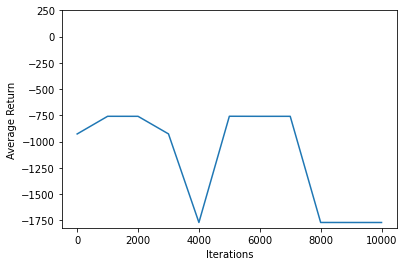

In [83]:
#Create the plot 
import matplotlib
import matplotlib.pyplot as plt
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

## Test de l'agent après l'entaienement

In [84]:
#Test after training
test_py_env = BreakoutEnv(visualize=False) 

#Convert into tf environment
test_env = tf_py_environment.TFPyEnvironment(test_py_env)
avg_return = compute_avg_return(test_env, agent.policy, num_eval_episodes)
print("results",avg_return)

results -1769.8
